# WikiNLI experiments

### In this notebook, we'll run experiments to try to perform textual entailment using SVM and Logistic Regression

**imports**

In [1]:
# stdlib
from pathlib import Path
import json
import random
import itertools
from collections import Counter, namedtuple
from functools import lru_cache, wraps
import pickle

# packages
from tqdm import tqdm_notebook as tqdm
import textwrap
from textdistance import levenshtein, cosine
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats

# ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, linear_model
from sklearn.feature_extraction import DictVectorizer
# nltk
import nltk
from nltk.tokenize import PunktSentenceTokenizer
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import sentiwordnet as swn, wordnet as wn

### define what an 'entry' should look like

In [2]:
Entry = namedtuple('Entry', sorted(['negation', 'evidence', 'context', 'url', 'id', 'claim', 'wikipageid']))

#### load train/test data

In [3]:
trainpath = Path('../out2/db_3_annot_train.jsonl')
testpath = Path('../out2/db_3_annot_test.jsonl')
with trainpath.open('r') as f:
    entries = [Entry(**json.loads(line[:-1])) for line in f]
# with testpath.open('r') as f:
#     test = [Entry(**json.loads(line[:-1])) for line in f]
# DO NOT USE ACTUAL TEST SET; USE 30% of the train set as dev set instead
trainsize = int(len(entries)*.7)
train, test = entries[:trainsize], entries[trainsize:]
print('loaded {} entries from the annotated train set'.format(len(train)))
print('loaded {} entries from the annotated dev set'.format(len(test)))

loaded 17043 entries from the annotated train set
loaded 7305 entries from the annotated dev set


In [4]:
punkt = PunktSentenceTokenizer()
# @lru_cache(maxsize=None)
def get_evidence(entry):
    '''
    retrieves evidence and returns generator of sentences from it
    '''
    prefix = '../refdata/wiki-refdata'
    evidencefile = Path(prefix) / entry.evidence
    try:
        with evidencefile.open('r', errors='ignore') as f:
            text = f.read()
        for item in punkt.tokenize(text):
            yield item
    except (FileNotFoundError, OSError) as e:
        print(entry.id, entry.evidence)
        raise

In [5]:
def get_relevant(claim, evids_generator, top=5, algorithm=levenshtein):
    '''
    picks the top so many sentences from evidence file that are relevant to the claim.
    algorithm must be an instance of some textdistance class with the method
    'normalized_distance' that returns a number between (0,1) with two strings as input.
    returns the top n most relevant sentences and the score of the most relevant
    '''
    distfn = lambda candidate: algorithm.normalized_distance(claim, candidate)
    
    smallest_dist = float('+inf')
    evids = [*evids_generator]
    for evid in evids:
        dist = distfn(evid)
        smallest_dist = min(smallest_dist, dist)

    return [*sorted(evids, key=distfn)][:top], smallest_dist

In [6]:
def plot_coefficients(classifier, feature_names, top_features=20, desc=''):
    '''
    a convenient method to visualize top features a classifier relies on.
    borrowed from:
    # https://medium.com/@aneesha/
       visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14
    '''
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    plt.title(desc)
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

#### Loading the data from our dataset

In [7]:
def get_train_repertoire(maxlen=float('inf')):
    trainlen = len(train)
    trainlen = min(maxlen, trainlen)
    return train[:trainlen]
    return [train[:trainlen//2], train[trainlen//2:2*(trainlen//2)]]
    
def get_test_repertoire(maxlen=float('inf')):
    testlen = len(test)
    testlen = min(maxlen, testlen)
    return test[:testlen]
    return [test[:testlen//2], test[testlen//2:2*(testlen//2)]]

### Preprocessing

In [8]:
def tokenize(claim, ev):
    '''
    tokenizes two sentences and returns in a list
    '''
    return nltk.word_tokenize(claim.lower()), nltk.word_tokenize(ev.lower())

def pos_tag(claim, ev):
    '''
    returns two lists one each for claim and evidence
    formatted like so: [(token, POS_tag), ...]
    '''
    return nltk.pos_tag(claim), nltk.pos_tag(ev)

def word_difference(claim, ev):
    '''
    a method to take the symmetric difference between two lists of
    (token, POS) pairs, one each for the claim and evidence-sentence.
    returns in the same format but with only the words in symmetric
    difference (disregards tag in computing the symmetric difference)
    '''
    w1 = set([e[0] for e in claim])
    w2 = set([e[0] for e in ev])
    diff = w1.symmetric_difference(w2)
    claim = [e for e in claim if e[0] in diff]
    ev = [e for e in ev if e[0] in diff]
    return claim, ev

def preprocess(claim, ev):
    claim, ev = tokenize(claim, ev)
    claim, ev = pos_tag(claim, ev)
    claim, ev = word_difference(claim, ev)
    return claim, ev

### Feature extraction

In [9]:
sentim_analyzer = SentimentAnalyzer()

def nltkpos_to_wn(tag):
    '''
    convert NLTK part-of-speech tag to one of the four WordNet tags (or None)
    '''
    if 'NN' in tag:
        return wn.NOUN
    if 'VB' in tag:
        return wn.VERB
    if 'RB' in tag:
        return wn.ADV
    if 'JJ' in tag:
        return wn.ADJ
    return None

def antonym(claim, ev):
    '''
    provides an antonym similarity score measuring:
    how similar are words in one collection to antonyms in another
    '''
    antC = []
    synC = []
    antE = []
    synE = []
    for w, pos in claim:
        wnpos = nltkpos_to_wn(pos)
        try:
            synC += [wn.synsets(w, pos=wnpos)[0]]
        except IndexError:
            continue
    for w, pos in ev:
        wnpos = nltkpos_to_wn(pos)
        try:
            synE += [wn.synsets(w, pos=wnpos)[0]]
        except IndexError:
            continue
    for syn in synC:
        try:
            antC += [syn.lemmas()[0].antonyms()[0].synset()]
        except IndexError:
            continue
    for syn in synE:
        try:
            antE += [syn.lemmas()[0].antonyms()[0].synset()]
        except IndexError:
            continue
    
    total = 0
    totalsim = 0
    maxsim = 0
    for a, s in itertools.product(antC, synE):
        total += 1
        sim = wn.path_similarity(a, s) or 0
        totalsim += sim
        maxsim = max(maxsim, sim)
    for a, s in itertools.product(synC, antE):
        total += 1
        sim = wn.path_similarity(a, s) or 0
        totalsim += sim
        maxsim = max(maxsim, sim)
    
    return totalsim/max(1, total), maxsim


def sentiment(claim, ev):
    '''
    takes in two collections, one for the claim and another for evidence
    retuns [1] the avg sentiment in claim, [2] the max sentiment in claim, 
    and [3] the difference between the avg claim sentiment and avg ev sentiment
    '''
    synC = []
    synE = []
    for w, pos in claim:
        wnpos = nltkpos_to_wn(pos)
        try:
            synC += [[*swn.senti_synsets(w, pos=wnpos)][0]]
        except IndexError:
            continue
    for w, pos in ev:
        wnpos = nltkpos_to_wn(pos)
        try:
            synE += [[*swn.senti_synsets(w, pos=wnpos)][0]]
        except IndexError:
            continue
            
    total = 0
    totalsen = 0
    maxsen = 0
    avgsen = None
    for a in synC:
        total += 1
        sen = a.pos_score() - a.neg_score()
        totalsen += sen
        maxsen = max(maxsen, sen)
    avgsen = totalsen/max(1, total)
    #
    
    total = 0
    totaldiff = 0
    maxdiff = 0
    sumC = sum(a.pos_score()-a.neg_score() for a in synC)/max(1, len(synC))
    sumE = sum(a.pos_score()-a.neg_score() for a in synE)/max(1, len(synE))
    
    return avgsen, maxsen, sumC-sumE
    
    
def swnscore(tokens):
    '''
    returns the absolute sentiment (pos minus neg) of a collection of tokens
    '''
    pos, neg, obj = 0, 0, 0
    for token in tokens:
        for s in swn.senti_synsets(token):
            pos += s.pos_score()
            neg += s.neg_score()
    return pos - neg


def discretesentifeature(claim, ev):
    '''
    returns 1 if both, claim and evidence have the same overall sentiment
    label (i.e., 1 if both are positive or both negative) and 0 otherwise
    '''
    cscore = swnscore(claim)
    escore = swnscore(claim)
    return 1 if cscore*escore > 0 else 0
    

def unigrams(claim, ev):
    # sentim_analyzer.extract_features('this is more text')
    # print(claim.union(ev))
    words = [e[0] for e in claim+ev]
    return sentim_analyzer.unigram_word_feats(words, top_n=1)

def wordpair(claim, ev):
    # cartesian product of two iterables
    c = [e[0] for e in claim]
    e = [e[0] for e in ev]
    return set(itertools.product(c, e))


In [ ]:
@lru_cache(maxsize=None)
def get_features(entry, label):
    claim = entry.claim if label == 1 else entry.negation
    ([ev], score) = get_relevant(claim, get_evidence(entry), top=1)
    
    claim, ev = preprocess(claim, ev)
    fwordpair = {str(p): 1 for p in wordpair(claim, ev)}
    fsentiment = sentiment(claim, ev)
    fantonym = antonym(claim, ev)
    
    return claim, [fwordpair, fsentiment, fantonym]

In [18]:
def make_featureset(entry, label=1, exclude=[]):
    '''
    a method to aggregate and extract features from our dataset,
    and return them in a tidy manner so that we can run experiments
    
    the method isn't actually passed any data, but only a slice that it
    will use together with 
    '''
    claim, [fwordpair, fsentiment, fantonym] = get_features(entry, label)
    
    fset = dict()
    if 'wordpair' not in exclude: 
        fset.update(fwordpair)
    if 'sentiment' not in exclude:
        avgsen, maxsen, diffsen = fsentiment
        fset.update({'avgsen': avgsen, 'maxsen': maxsen, 'diffsen': diffsen})
    if 'antonym' not in exclude:
        avgant, maxant = fantonym
        fset.update({'avgant': avgant, 'maxant': maxant})
        
    return fset
    
    
def featurize(maxlen=float('inf'), label=1, task='train', exclude=[], mode='dev'):
    '''
    a wrapper method that goes through entries and calls get_features on
    each one. the advantage is that get_features is a cached method, so
    hopefully this saves time in the same session and across multiple runs
    '''
    if mode == 'dev':
        get_data = get_train_repertoire if task == 'train' else get_test_repertoire
    else:
        raise ValueError('test set unavailable like this. please modify cells above')
    fsets = []
    for entry in tqdm(get_data(maxlen=maxlen), 
                      desc='making fset for size={} label={}, task={}'.format(maxlen, label, task)):
        try:
            fset = make_featureset(entry, label, exclude)
        except (FileNotFoundError, OSError) as e:
            continue
        fsets += [(fset, label)]
        
    random.shuffle(fsets)
    return fsets

In [19]:
for task in ['train', 'test']:
    for i, excl in enumerate((['sentiment', 'antonym'], ['antonym'], ['sentiment'], ['wordpair'], [])):
        print(i)
        stuff = featurize(label=0, task=task, exclude=excl) + featurize(label=1, task=task, exclude=excl)
        p = Path('cached') / ('_'.join(sorted({'wordpair', 'sentiment', 'antonym'}.difference(set(excl)))) + '_' + task + '.cache')
        with p.open('wb') as f:
            pickle.dump(stuff, f)
        with (Path('cached')/'stats.txt').open('w') as f:
            f.write(str(len(stuff)))

0


1


2


3


4


0


1


2


3


4


In [ ]:
raise

### Define an experiment class for easy pipelining and reproducibility

In [23]:
param_dist = {'max_iter': [5000],
              #'C': scipy.stats.uniform(.1, 5),
              'C': np.arange(.2,3.2,.1)}

class Experiment:
    name = None
    baseline = ['wordpair']
    addons = ['sentiment', 'antonym']
    clf = dict()
    vec = dict()
    data, test = dict(), dict()
    
    def __init__(self, name, clfcls=svm.LinearSVC, **kwargs):
        self.name = name
        self.clfcls = clfcls
        self.kwargs = kwargs
        
    def setup(self, maxlen=2048, exclude=[]):
        '''
        gets data and sets the feature encoder up for usage.
        MUST be called before calling train() otherwise results may be unreliable
        '''
        self.key = tuple(exclude)
        
#         if self.key not in self.data:
#             self.data[self.key] = featurize(maxlen, 1, 'train', exclude) + featurize(maxlen, 0, 'train', exclude)
#         if self.key not in self.test:
#             self.test[self.key] = featurize(maxlen, 1, 'test', exclude) + featurize(maxlen, 0, 'test', exclude)
        
        self.vec[self.key] = DictVectorizer()
        self.vec[self.key].fit(x[0] for x in self.data[self.key]+self.test[self.key])
#         self.clf[self.key] = GridSearchCV(self.clfcls(**self.kwargs), param_grid=param_dist, iid=False, cv=3)
        self.clf[self.key] = self.clfcls(**self.kwargs)
        
    def train(self):
        '''
        trains the classifier on maxlen datapoints
        '''
        assert self.data.get(self.key, None) is not None, 'forgot to preprocess?'
                
        examples = self.vec[self.key].transform([x[0] for x in self.data[self.key]])
        labels = [x[1] for x in self.data[self.key]]
        self.clf[self.key].fit(examples, labels)
        
    
    def evaluate(self):
        examples = self.vec[self.key].transform([x[0] for x in self.test[self.key]])
        labels = [x[1] for x in self.test[self.key]]
        return self.clf[self.key].score(examples, labels)
        
        
    def incremental(self, maxlen=2048, plot=False):
        '''
        among the add-ons, do an inclusion-exclusion of each feature
        and go through the entire model training and evaluation process
        '''
#         p = Path('traindata{}.cache'.format(maxlen))
#         if p.exists():
#             print('found cached data at', p)
#             with p.open('rb') as f:
#                 self.data = pickle.load(f)
#         p = Path('testdata{}.cache'.format(maxlen))
#         if p.exists():
#             print('found cached data at', p)
#             with p.open('rb') as f:
#                 self.test = pickle.load(f)
                
        def pipeline(exclude=[]):
            include = set(self.baseline+self.addons).difference(set(exclude))
            print('running pipeline for featureset=', include)
            with Path('cached/{}_train.cache'.format('_'.join(sorted(include)))).open('rb') as f:
                self.data[tuple(exclude)] = pickle.load(f)
            with Path('cached/{}_test.cache'.format('_'.join(sorted(include)))).open('rb') as f:
                self.test[tuple(exclude)] = pickle.load(f)
            self.setup(maxlen, exclude)
            self.train()
            return self.evaluate(), include

        
        results = []
        
        results.append(pipeline(exclude=['sentiment', 'antonym']))
        results.append(pipeline(exclude=['sentiment']))
        results.append(pipeline(exclude=['antonym']))
        
        results.append(pipeline(exclude=['wordpair']))
        results.append(pipeline(exclude=['wordpair', 'sentiment']))
        results.append(pipeline(exclude=['wordpair', 'antonym']))
        
        results.append(pipeline())
        
        self.results = results
        
#         p = Path('traindata{}.cache'.format(maxlen))
#         if not p.exists():
#             print('storing cached data at', p)
#             with p.open('wb') as f:
#                 pickle.dump(obj=self.data, file=f)
#         p = Path('testdata{}.cache'.format(maxlen))
#         if not p.exists():
#             print('storing cached data at', p)
#             with p.open('wb') as f:
#                 pickle.dump(obj=self.test, file=f)
        
        if plot:
            raise NotImplementedError
        
        return results
       
    def visualize_arguments(self):
        '''
        iterates through experiments and provides kwarguments to the plot function from above,
        in order to visualize top features
        '''
        for key in sorted(self.clf.keys(), key=lambda x: -len(x)):
            # print(key)
            yield {'desc': set(self.baseline+self.addons).difference(set(key)), 
                   'classifier': self.clf[key], 
                   'feature_names': self.vec[key].get_feature_names()}

In [75]:
# Utility function to report best scores
def report_results(results, n_top=6):
    for i in range(1, max(1, n_top + 1)):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### Make instances of it and run the experiment

##### SVM: LinearSVC

In [ ]:
# run the linearSVC experiments
svmexp = Experiment(name='pilotSVM', clfcls=svm.LinearSVC, max_iter=1000)
_ = svmexp.incremental()

running pipeline for featureset= {'wordpair'}


/home/aalok/.local/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


running pipeline for featureset= {'wordpair', 'antonym'}


In [73]:
print(*('{:>.4f} \t{}'.format(acc, sorted(feat)) for acc, feat in sorted(svmexp.results)), sep='\n')

0.5358 	['antonym']
0.5686 	['sentiment']
0.5797 	['antonym', 'sentiment']
0.5857 	['wordpair']
0.5907 	['sentiment', 'wordpair']
0.5983 	['antonym', 'wordpair']
0.6010 	['antonym', 'sentiment', 'wordpair']


In [79]:
for key, random_search in sorted(svmexp.clf.items()):
    print('='*64)
    print(set(svmexp.baseline+svmexp.addons).difference(set(key)))
    report_results(random_search.cv_results_, n_top=2)

{'sentiment', 'wordpair', 'antonym'}
Model with rank: 1
Mean validation score: 0.475 (std: 0.007)
Parameters: {'max_iter': 5000, 'C': 2.6999999999999997}

Model with rank: 1
Mean validation score: 0.475 (std: 0.007)
Parameters: {'max_iter': 10000, 'C': 2.6999999999999997}

{'wordpair', 'sentiment'}
Model with rank: 1
Mean validation score: 0.474 (std: 0.006)
Parameters: {'max_iter': 5000, 'C': 2.6999999999999997}

Model with rank: 1
Mean validation score: 0.474 (std: 0.006)
Parameters: {'max_iter': 10000, 'C': 2.6999999999999997}

{'wordpair', 'antonym'}
Model with rank: 1
Mean validation score: 0.462 (std: 0.002)
Parameters: {'max_iter': 5000, 'C': 1.6999999999999997}

Model with rank: 1
Mean validation score: 0.462 (std: 0.002)
Parameters: {'max_iter': 10000, 'C': 1.6999999999999997}

{'wordpair'}
Model with rank: 1
Mean validation score: 0.450 (std: 0.002)
Parameters: {'max_iter': 5000, 'C': 1.6999999999999997}

Model with rank: 1
Mean validation score: 0.450 (std: 0.002)
Parameters

In [21]:
# for kwargs in svmexp.visualize_arguments():
#     if len(kwargs['feature_names']) >= 5:
#         plot_coefficients(**kwargs, top_features=min(20, len(kwargs['feature_names'])))
#     else:
#         continue

##### LR: LogisticRegression

In [15]:
# run the logistic regression experiments
lrexp = Experiment(name='pilotLR', clfcls=linear_model.LogisticRegression, max_iter=1000, solver='sag')
_ = lrexp.incremental(maxlen=4096)

found cached data at traindata4096.cache
found cached data at testdata4096.cache
running pipeline for featureset= {'wordpair'}
running pipeline for featureset= {'wordpair', 'antonym'}
running pipeline for featureset= {'wordpair', 'sentiment'}
running pipeline for featureset= {'sentiment', 'antonym'}
running pipeline for featureset= {'antonym'}
running pipeline for featureset= {'sentiment'}
running pipeline for featureset= {'sentiment', 'wordpair', 'antonym'}


In [72]:
print(*('{:>.4f} \t{}'.format(acc, sorted(feat)) for acc, feat in sorted(lrexp.results)), sep='\n')

0.5339 	['antonym']
0.5679 	['sentiment']
0.5787 	['antonym', 'sentiment']
0.6128 	['antonym', 'wordpair']
0.6149 	['wordpair']
0.6183 	['antonym', 'sentiment', 'wordpair']
0.6193 	['sentiment', 'wordpair']


In [71]:
# for kwargs in lrexp.visualize_arguments():
#     if len(kwargs['feature_names']) >= 5:
#         plot_coefficients(**kwargs, top_features=min(20, len(kwargs['feature_names'])))
#     else:
#         continue

### Visualize all the experiments together

In [17]:
def barplot(A, B, clfA='LinearSVC', clfB='LogisticRegression'):
    # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/
    #    barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    sortkey = lambda pair: (len(pair[1]), pair[1])
    A, labels = [*zip(*sorted(A, key=sortkey))]
    B, _ = [*zip(*sorted(B, key=sortkey))]
    
    labels = ['+\n'.join(label) for label in labels]
    
    x = np.arange(len(A))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2-.05, A, width, label=clfA, color=(.1,.1,.1,.1), edgecolor='blue')
    rects2 = ax.bar(x + width/2+.05, B, width, label=clfB)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by learning algorithm and featureset')
    plt.xticks(x, labels, rotation=30)
    plt.ylim(.45, .7)
    ax.margins(0.1, 0.5)
    ax.legend(loc='upper left')


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:>.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

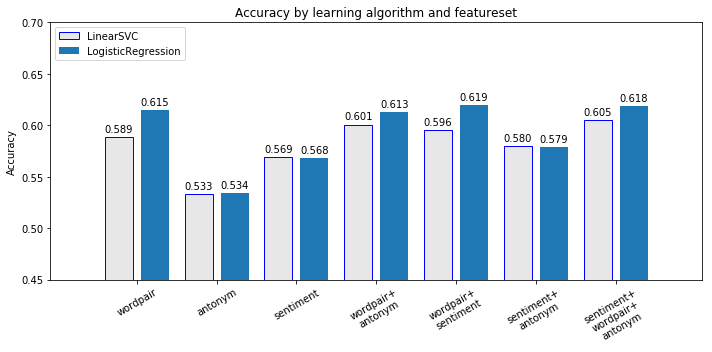

In [18]:
barplot(svmexp.results, lrexp.results)